In [1]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
np.random.seed(100)   
tf.random.set_seed(100)

In [2]:
# Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

In [4]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [5]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [6]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[30399:53199] 
Y_train_SS = Y_train_SS[30399:53199]
Y_train_V = Y_train_V[30399:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 22590
Validation samples: 7570
Testing samples: 15140


In [7]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [8]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

**Define Data-Driven Model**

In [9]:
# Define MLP
def MLP_Data():

  # Define inputs
  X_train = layers.Input(shape=(600),name='X_train')    

  # Prediction: Shear Stress + Slip Rate 
  x = layers.Dense(128,kernel_initializer = 'normal', activation="relu")(X_train)
  x = layers.Dense(64,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(32,kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(16, kernel_initializer = 'normal', activation="relu")(x)
  x = layers.Dense(8, kernel_initializer = 'normal', activation="relu")(x)
  ss_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)
  v_pred = layers.Dense(1,kernel_initializer = 'normal',activation="linear")(x)

  model = keras.Model(inputs=[X_train],outputs=[ss_pred,v_pred])
  return model

In [10]:
# Model Summary
model=MLP_Data()
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

Train on 22590 samples, validate on 7570 samples
Epoch 1/100
22590/22590 [==============================] - ETA: 0s - loss: 0.0505 - dense_5_loss: 0.0411 - dense_6_loss: 0.0095 - dense_5_mse: 0.0411 - dense_6_mse: 0.0095
Epoch 1: val_loss improved from inf to 0.03184, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


22590/22590 [==============================] - 3s 148us/sample - loss: 0.0505 - dense_5_loss: 0.0411 - dense_6_loss: 0.0095 - dense_5_mse: 0.0411 - dense_6_mse: 0.0095 - val_loss: 0.0318 - val_dense_5_loss: 0.0248 - val_dense_6_loss: 0.0071 - val_dense_5_mse: 0.0248 - val_dense_6_mse: 0.0071
Epoch 2/100
22304/22590 [============================>.] - ETA: 0s - loss: 0.0235 - dense_5_loss: 0.0176 - dense_6_loss: 0.0059 - dense_5_mse: 0.0176 - dense_6_mse: 0.0059
Epoch 2: val_loss improved from 0.03184 to 0.02557, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 2s 104us/sample - loss: 0.0234 - dense_5_loss: 0.0175 - dense_6_loss: 0.0059 - dense_5_mse: 0.0175 - dense_6_mse: 0.0059 - val_loss: 0.0256 - val_dense_5_loss: 0.0193 - val_dense_6_loss: 0.0062 - val_dense_5_mse: 0.0193 - val_dense_6_mse: 0.0062
Epoch 3/100
22208/22590 [============================>.] - ETA: 0s - loss: 0.0217 - dense_5_loss: 0.0167 - dense_6_loss: 0.0051 - dense_5_mse: 0.0167 - dense_6_mse: 0.0051
Epoch 3: val_loss improved from 0.02557 to 0.02435, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 2s 94us/sample - loss: 0.0217 - dense_5_loss: 0.0166 - dense_6_loss: 0.0051 - dense_5_mse: 0.0166 - dense_6_mse: 0.0051 - val_loss: 0.0243 - val_dense_5_loss: 0.0187 - val_dense_6_loss: 0.0057 - val_dense_5_mse: 0.0187 - val_dense_6_mse: 0.0057
Epoch 4/100
22590/22590 [==============================] - ETA: 0s - loss: 0.0200 - dense_5_loss: 0.0152 - dense_6_loss: 0.0048 - dense_5_mse: 0.0152 - dense_6_mse: 0.0048
Epoch 4: val_loss did not improve from 0.02435
22590/22590 [==============================] - 1s 52us/sample - loss: 0.0200 - dense_5_loss: 0.0152 - dense_6_loss: 0.0048 - dense_5_mse: 0.0152 - dense_6_mse: 0.0048 - val_loss: 0.0269 - val_dense_5_loss: 0.0214 - val_dense_6_loss: 0.0055 - val_dense_5_mse: 0.0214 - val_dense_6_mse: 0.0055
Epoch 5/100
22208/22590 [============================>.] - ETA: 0s - loss: 0.0188 - dense_5_loss: 0.0140 - dense_6_loss: 0.0047 - dense_5_mse: 0.0140 - dense_6_mse: 0.0047
Epoch 5: val_loss improve

22590/22590 [==============================] - 2s 94us/sample - loss: 0.0188 - dense_5_loss: 0.0140 - dense_6_loss: 0.0047 - dense_5_mse: 0.0140 - dense_6_mse: 0.0047 - val_loss: 0.0217 - val_dense_5_loss: 0.0161 - val_dense_6_loss: 0.0056 - val_dense_5_mse: 0.0161 - val_dense_6_mse: 0.0056
Epoch 6/100
21536/22590 [===========================>..] - ETA: 0s - loss: 0.0175 - dense_5_loss: 0.0128 - dense_6_loss: 0.0047 - dense_5_mse: 0.0128 - dense_6_mse: 0.0047
Epoch 6: val_loss improved from 0.02170 to 0.02115, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 2s 96us/sample - loss: 0.0175 - dense_5_loss: 0.0128 - dense_6_loss: 0.0047 - dense_5_mse: 0.0128 - dense_6_mse: 0.0047 - val_loss: 0.0212 - val_dense_5_loss: 0.0155 - val_dense_6_loss: 0.0056 - val_dense_5_mse: 0.0155 - val_dense_6_mse: 0.0056
Epoch 7/100
22240/22590 [============================>.] - ETA: 0s - loss: 0.0165 - dense_5_loss: 0.0118 - dense_6_loss: 0.0047 - dense_5_mse: 0.0118 - dense_6_mse: 0.0047
Epoch 7: val_loss did not improve from 0.02115
22590/22590 [==============================] - 1s 51us/sample - loss: 0.0165 - dense_5_loss: 0.0118 - dense_6_loss: 0.0047 - dense_5_mse: 0.0118 - dense_6_mse: 0.0047 - val_loss: 0.0212 - val_dense_5_loss: 0.0157 - val_dense_6_loss: 0.0055 - val_dense_5_mse: 0.0157 - val_dense_6_mse: 0.0055
Epoch 8/100
22400/22590 [============================>.] - ETA: 0s - loss: 0.0155 - dense_5_loss: 0.0108 - dense_6_loss: 0.0046 - dense_5_mse: 0.0108 - dense_6_mse: 0.0046
Epoch 8: val_loss improve

22590/22590 [==============================] - 2s 103us/sample - loss: 0.0156 - dense_5_loss: 0.0108 - dense_6_loss: 0.0047 - dense_5_mse: 0.0108 - dense_6_mse: 0.0047 - val_loss: 0.0180 - val_dense_5_loss: 0.0124 - val_dense_6_loss: 0.0056 - val_dense_5_mse: 0.0124 - val_dense_6_mse: 0.0056
Epoch 9/100
22464/22590 [============================>.] - ETA: 0s - loss: 0.0145 - dense_5_loss: 0.0097 - dense_6_loss: 0.0047 - dense_5_mse: 0.0097 - dense_6_mse: 0.0047
Epoch 9: val_loss improved from 0.01799 to 0.01633, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 2s 96us/sample - loss: 0.0144 - dense_5_loss: 0.0097 - dense_6_loss: 0.0047 - dense_5_mse: 0.0097 - dense_6_mse: 0.0047 - val_loss: 0.0163 - val_dense_5_loss: 0.0108 - val_dense_6_loss: 0.0055 - val_dense_5_mse: 0.0108 - val_dense_6_mse: 0.0055
Epoch 10/100
21600/22590 [===========================>..] - ETA: 0s - loss: 0.0130 - dense_5_loss: 0.0083 - dense_6_loss: 0.0047 - dense_5_mse: 0.0083 - dense_6_mse: 0.0047
Epoch 10: val_loss improved from 0.01633 to 0.01375, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 2s 94us/sample - loss: 0.0130 - dense_5_loss: 0.0083 - dense_6_loss: 0.0047 - dense_5_mse: 0.0083 - dense_6_mse: 0.0047 - val_loss: 0.0137 - val_dense_5_loss: 0.0083 - val_dense_6_loss: 0.0055 - val_dense_5_mse: 0.0083 - val_dense_6_mse: 0.0055
Epoch 11/100
22496/22590 [============================>.] - ETA: 0s - loss: 0.0112 - dense_5_loss: 0.0065 - dense_6_loss: 0.0047 - dense_5_mse: 0.0065 - dense_6_mse: 0.0047
Epoch 11: val_loss did not improve from 0.01375
22590/22590 [==============================] - 1s 50us/sample - loss: 0.0112 - dense_5_loss: 0.0065 - dense_6_loss: 0.0047 - dense_5_mse: 0.0065 - dense_6_mse: 0.0047 - val_loss: 0.0139 - val_dense_5_loss: 0.0085 - val_dense_6_loss: 0.0054 - val_dense_5_mse: 0.0085 - val_dense_6_mse: 0.0054
Epoch 12/100
22144/22590 [============================>.] - ETA: 0s - loss: 0.0103 - dense_5_loss: 0.0056 - dense_6_loss: 0.0046 - dense_5_mse: 0.0056 - dense_6_mse: 0.0046
Epoch 12: val_loss imp

22590/22590 [==============================] - 3s 130us/sample - loss: 0.0103 - dense_5_loss: 0.0056 - dense_6_loss: 0.0047 - dense_5_mse: 0.0056 - dense_6_mse: 0.0047 - val_loss: 0.0112 - val_dense_5_loss: 0.0058 - val_dense_6_loss: 0.0054 - val_dense_5_mse: 0.0058 - val_dense_6_mse: 0.0054
Epoch 13/100
21568/22590 [===========================>..] - ETA: 0s - loss: 0.0096 - dense_5_loss: 0.0051 - dense_6_loss: 0.0045 - dense_5_mse: 0.0051 - dense_6_mse: 0.0045
Epoch 13: val_loss improved from 0.01125 to 0.01003, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 3s 125us/sample - loss: 0.0095 - dense_5_loss: 0.0051 - dense_6_loss: 0.0044 - dense_5_mse: 0.0051 - dense_6_mse: 0.0044 - val_loss: 0.0100 - val_dense_5_loss: 0.0055 - val_dense_6_loss: 0.0045 - val_dense_5_mse: 0.0055 - val_dense_6_mse: 0.0045
Epoch 14/100
22048/22590 [============================>.] - ETA: 0s - loss: 0.0083 - dense_5_loss: 0.0052 - dense_6_loss: 0.0031 - dense_5_mse: 0.0052 - dense_6_mse: 0.0031
Epoch 14: val_loss did not improve from 0.01003
22590/22590 [==============================] - 1s 53us/sample - loss: 0.0082 - dense_5_loss: 0.0052 - dense_6_loss: 0.0030 - dense_5_mse: 0.0052 - dense_6_mse: 0.0030 - val_loss: 0.0120 - val_dense_5_loss: 0.0078 - val_dense_6_loss: 0.0042 - val_dense_5_mse: 0.0078 - val_dense_6_mse: 0.0042
Epoch 15/100
21952/22590 [============================>.] - ETA: 0s - loss: 0.0071 - dense_5_loss: 0.0048 - dense_6_loss: 0.0023 - dense_5_mse: 0.0048 - dense_6_mse: 0.0023
Epoch 15: val_loss im

22590/22590 [==============================] - 2s 94us/sample - loss: 0.0071 - dense_5_loss: 0.0048 - dense_6_loss: 0.0023 - dense_5_mse: 0.0048 - dense_6_mse: 0.0023 - val_loss: 0.0068 - val_dense_5_loss: 0.0048 - val_dense_6_loss: 0.0020 - val_dense_5_mse: 0.0048 - val_dense_6_mse: 0.0020
Epoch 16/100
21536/22590 [===========================>..] - ETA: 0s - loss: 0.0067 - dense_5_loss: 0.0046 - dense_6_loss: 0.0021 - dense_5_mse: 0.0046 - dense_6_mse: 0.0021
Epoch 16: val_loss improved from 0.00675 to 0.00608, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check


22590/22590 [==============================] - 2s 98us/sample - loss: 0.0067 - dense_5_loss: 0.0045 - dense_6_loss: 0.0021 - dense_5_mse: 0.0045 - dense_6_mse: 0.0021 - val_loss: 0.0061 - val_dense_5_loss: 0.0044 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 0.0044 - val_dense_6_mse: 0.0016
Epoch 17/100
21696/22590 [===========================>..] - ETA: 0s - loss: 0.0063 - dense_5_loss: 0.0043 - dense_6_loss: 0.0020 - dense_5_mse: 0.0043 - dense_6_mse: 0.0020
Epoch 17: val_loss did not improve from 0.00608
22590/22590 [==============================] - 1s 56us/sample - loss: 0.0063 - dense_5_loss: 0.0043 - dense_6_loss: 0.0020 - dense_5_mse: 0.0043 - dense_6_mse: 0.0020 - val_loss: 0.0074 - val_dense_5_loss: 0.0053 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0053 - val_dense_6_mse: 0.0021
Epoch 18/100
21472/22590 [===========================>..] - ETA: 0s - loss: 0.0060 - dense_5_loss: 0.0042 - dense_6_loss: 0.0018 - dense_5_mse: 0.0042 - dense_6_mse: 0.0018
Epoch 18: val_loss did

22590/22590 [==============================] - 2s 97us/sample - loss: 0.0059 - dense_5_loss: 0.0041 - dense_6_loss: 0.0018 - dense_5_mse: 0.0041 - dense_6_mse: 0.0018 - val_loss: 0.0055 - val_dense_5_loss: 0.0042 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0042 - val_dense_6_mse: 0.0013
Epoch 20/100
21696/22590 [===========================>..] - ETA: 0s - loss: 0.0057 - dense_5_loss: 0.0039 - dense_6_loss: 0.0018 - dense_5_mse: 0.0039 - dense_6_mse: 0.0018
Epoch 20: val_loss did not improve from 0.00552
22590/22590 [==============================] - 1s 51us/sample - loss: 0.0057 - dense_5_loss: 0.0039 - dense_6_loss: 0.0018 - dense_5_mse: 0.0039 - dense_6_mse: 0.0018 - val_loss: 0.0074 - val_dense_5_loss: 0.0053 - val_dense_6_loss: 0.0021 - val_dense_5_mse: 0.0053 - val_dense_6_mse: 0.0021
Epoch 21/100
22590/22590 [==============================] - ETA: 0s - loss: 0.0051 - dense_5_loss: 0.0035 - dense_6_loss: 0.0016 - dense_5_mse: 0.0035 - dense_6_mse: 0.0016
Epoch 21: val_loss did

22590/22590 [==============================] - 2s 106us/sample - loss: 0.0050 - dense_5_loss: 0.0034 - dense_6_loss: 0.0015 - dense_5_mse: 0.0034 - dense_6_mse: 0.0015 - val_loss: 0.0048 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0035 - val_dense_6_mse: 0.0013
Epoch 24/100
21728/22590 [===========================>..] - ETA: 0s - loss: 0.0049 - dense_5_loss: 0.0034 - dense_6_loss: 0.0015 - dense_5_mse: 0.0034 - dense_6_mse: 0.0015
Epoch 24: val_loss did not improve from 0.00477
22590/22590 [==============================] - 1s 51us/sample - loss: 0.0049 - dense_5_loss: 0.0034 - dense_6_loss: 0.0015 - dense_5_mse: 0.0034 - dense_6_mse: 0.0015 - val_loss: 0.0055 - val_dense_5_loss: 0.0042 - val_dense_6_loss: 0.0013 - val_dense_5_mse: 0.0042 - val_dense_6_mse: 0.0013
Epoch 25/100
21536/22590 [===========================>..] - ETA: 0s - loss: 0.0046 - dense_5_loss: 0.0031 - dense_6_loss: 0.0015 - dense_5_mse: 0.0031 - dense_6_mse: 0.0015
Epoch 25: val_loss di

22590/22590 [==============================] - 2s 98us/sample - loss: 0.0038 - dense_5_loss: 0.0026 - dense_6_loss: 0.0012 - dense_5_mse: 0.0026 - dense_6_mse: 0.0012 - val_loss: 0.0047 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0033 - val_dense_6_mse: 0.0014
Epoch 32/100
21856/22590 [============================>.] - ETA: 0s - loss: 0.0039 - dense_5_loss: 0.0027 - dense_6_loss: 0.0012 - dense_5_mse: 0.0027 - dense_6_mse: 0.0012
Epoch 32: val_loss did not improve from 0.00466
22590/22590 [==============================] - 1s 54us/sample - loss: 0.0039 - dense_5_loss: 0.0027 - dense_6_loss: 0.0012 - dense_5_mse: 0.0027 - dense_6_mse: 0.0012 - val_loss: 0.0051 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 0.0016 - val_dense_5_mse: 0.0035 - val_dense_6_mse: 0.0016
Epoch 33/100
21888/22590 [============================>.] - ETA: 0s - loss: 0.0038 - dense_5_loss: 0.0026 - dense_6_loss: 0.0012 - dense_5_mse: 0.0026 - dense_6_mse: 0.0012
Epoch 33: val_loss imp

22590/22590 [==============================] - 2s 97us/sample - loss: 0.0038 - dense_5_loss: 0.0026 - dense_6_loss: 0.0012 - dense_5_mse: 0.0026 - dense_6_mse: 0.0012 - val_loss: 0.0043 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 8.8598e-04 - val_dense_5_mse: 0.0034 - val_dense_6_mse: 8.8757e-04
Epoch 34/100
21600/22590 [===========================>..] - ETA: 0s - loss: 0.0037 - dense_5_loss: 0.0026 - dense_6_loss: 0.0011 - dense_5_mse: 0.0026 - dense_6_mse: 0.0011
Epoch 34: val_loss did not improve from 0.00433
22590/22590 [==============================] - 1s 49us/sample - loss: 0.0037 - dense_5_loss: 0.0026 - dense_6_loss: 0.0011 - dense_5_mse: 0.0026 - dense_6_mse: 0.0011 - val_loss: 0.0045 - val_dense_5_loss: 0.0037 - val_dense_6_loss: 8.2391e-04 - val_dense_5_mse: 0.0037 - val_dense_6_mse: 8.2384e-04
Epoch 35/100
22016/22590 [============================>.] - ETA: 0s - loss: 0.0039 - dense_5_loss: 0.0027 - dense_6_loss: 0.0012 - dense_5_mse: 0.0027 - dense_6_mse: 0.0012
Epoch 

22590/22590 [==============================] - 2s 95us/sample - loss: 0.0033 - dense_5_loss: 0.0023 - dense_6_loss: 9.9505e-04 - dense_5_mse: 0.0023 - dense_6_mse: 9.9512e-04 - val_loss: 0.0039 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 6.4942e-04 - val_dense_5_mse: 0.0033 - val_dense_6_mse: 6.5035e-04
Epoch 43/100
21728/22590 [===========================>..] - ETA: 0s - loss: 0.0033 - dense_5_loss: 0.0023 - dense_6_loss: 9.5479e-04 - dense_5_mse: 0.0023 - dense_6_mse: 9.5479e-04
Epoch 43: val_loss did not improve from 0.00391
22590/22590 [==============================] - 1s 51us/sample - loss: 0.0033 - dense_5_loss: 0.0023 - dense_6_loss: 9.5702e-04 - dense_5_mse: 0.0023 - dense_6_mse: 9.5711e-04 - val_loss: 0.0054 - val_dense_5_loss: 0.0040 - val_dense_6_loss: 0.0014 - val_dense_5_mse: 0.0040 - val_dense_6_mse: 0.0014
Epoch 44/100
22496/22590 [============================>.] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0022 - dense_6_loss: 9.6095e-04 - dense_5_mse: 0.0022 - dense_

22590/22590 [==============================] - 2s 96us/sample - loss: 0.0031 - dense_5_loss: 0.0022 - dense_6_loss: 9.0488e-04 - dense_5_mse: 0.0022 - dense_6_mse: 9.0493e-04 - val_loss: 0.0037 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 7.7250e-04 - val_dense_5_mse: 0.0029 - val_dense_6_mse: 7.7388e-04
Epoch 47/100
22176/22590 [============================>.] - ETA: 0s - loss: 0.0031 - dense_5_loss: 0.0022 - dense_6_loss: 9.2051e-04 - dense_5_mse: 0.0022 - dense_6_mse: 9.2051e-04
Epoch 47: val_loss did not improve from 0.00368
22590/22590 [==============================] - 1s 62us/sample - loss: 0.0031 - dense_5_loss: 0.0022 - dense_6_loss: 9.1523e-04 - dense_5_mse: 0.0022 - dense_6_mse: 9.1522e-04 - val_loss: 0.0042 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 9.0645e-04 - val_dense_5_mse: 0.0033 - val_dense_6_mse: 9.0809e-04
Epoch 48/100
22304/22590 [============================>.] - ETA: 0s - loss: 0.0030 - dense_5_loss: 0.0021 - dense_6_loss: 9.0482e-04 - dense_5_mse: 0.0021 

22590/22590 [==============================] - 3s 117us/sample - loss: 0.0029 - dense_5_loss: 0.0021 - dense_6_loss: 8.5482e-04 - dense_5_mse: 0.0021 - dense_6_mse: 8.5479e-04 - val_loss: 0.0035 - val_dense_5_loss: 0.0029 - val_dense_6_loss: 6.0587e-04 - val_dense_5_mse: 0.0029 - val_dense_6_mse: 6.0653e-04
Epoch 57/100
21888/22590 [============================>.] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0020 - dense_6_loss: 8.1833e-04 - dense_5_mse: 0.0020 - dense_6_mse: 8.1833e-04
Epoch 57: val_loss did not improve from 0.00354
22590/22590 [==============================] - 1s 58us/sample - loss: 0.0028 - dense_5_loss: 0.0020 - dense_6_loss: 8.1075e-04 - dense_5_mse: 0.0020 - dense_6_mse: 8.1080e-04 - val_loss: 0.0046 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 0.0012 - val_dense_5_mse: 0.0034 - val_dense_6_mse: 0.0012
Epoch 58/100
22368/22590 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0019 - dense_6_loss: 8.0801e-04 - dense_5_mse: 0.0019 - dense

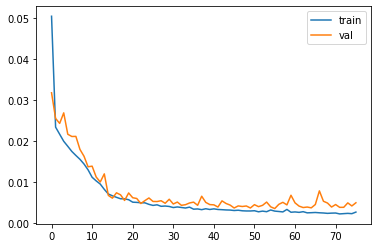

---Training time: 119.14966178 seconds ---


In [11]:
# Train The Model
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto') 
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Standalone/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()
print("---Training time: %0.8f seconds ---" % (end_time - start_time))

In [12]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation 
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.94333, Train (V) - 0.84444
R2 scores: Validation (SS) - 0.89962, Validation (V) - 0.81922
R2 scores: Testing (SS) - 0.80184, Testing (V) - 0.64992
RMSE scores: Train (SS) - 0.04270, Train (V) - 0.02706
RMSE scores: Validation (SS) - 0.06292, Validation (V) - 0.03163
RMSE scores: Testing (SS) - 0.09582, Testing (V) - 0.05047


In [13]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [14]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

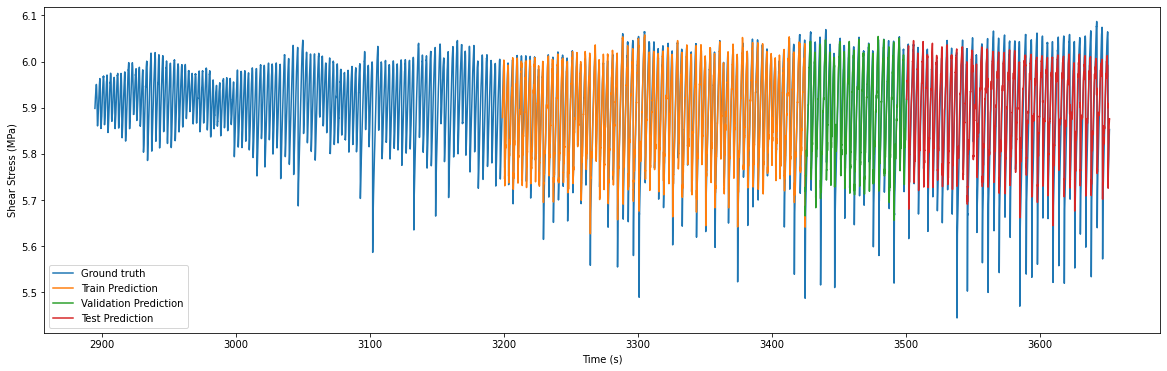

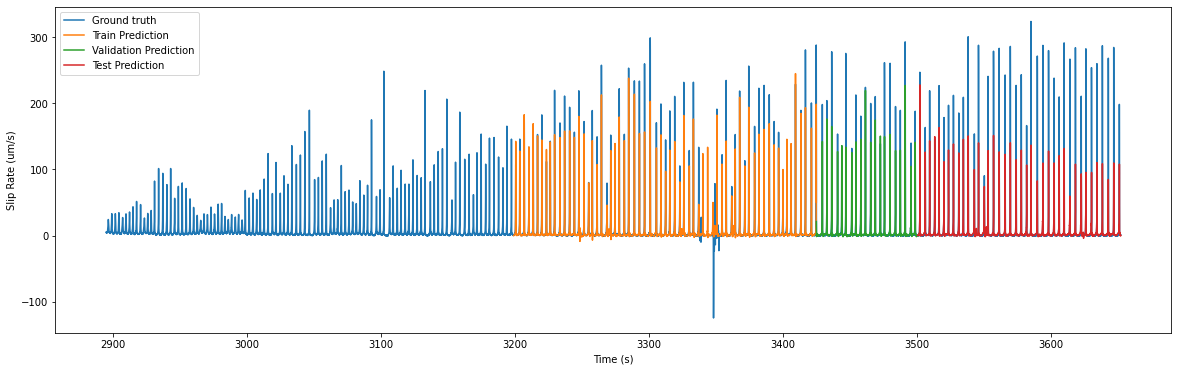

In [15]:
# Overall plot: SS & V
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[30399:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

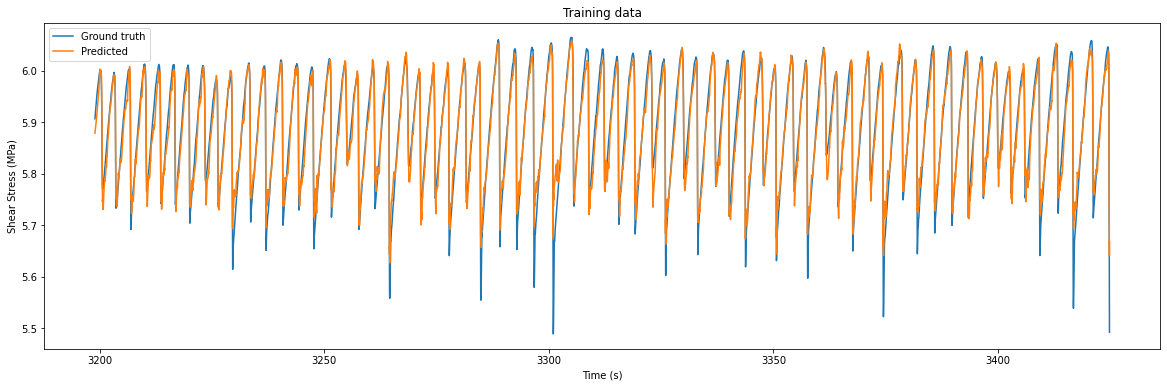

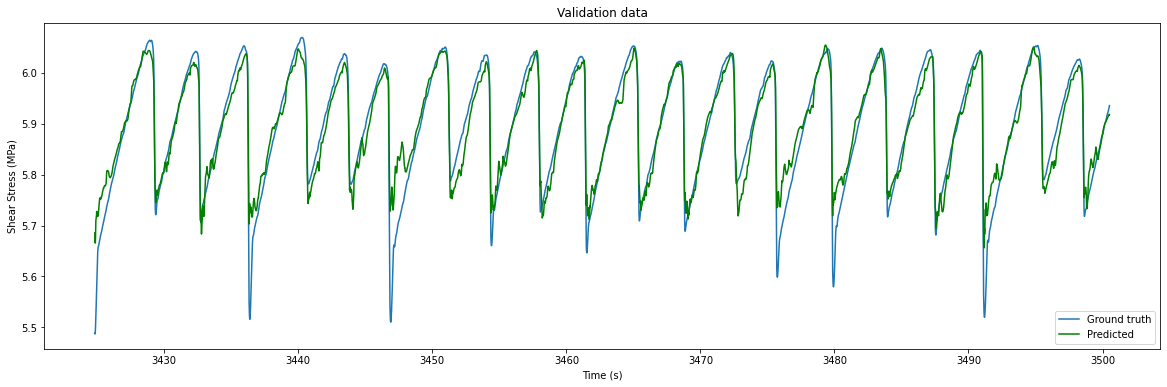

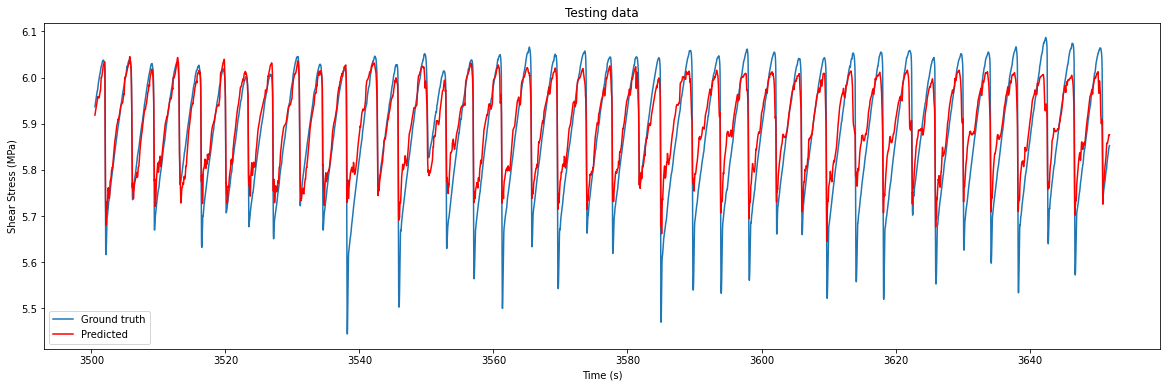

In [16]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

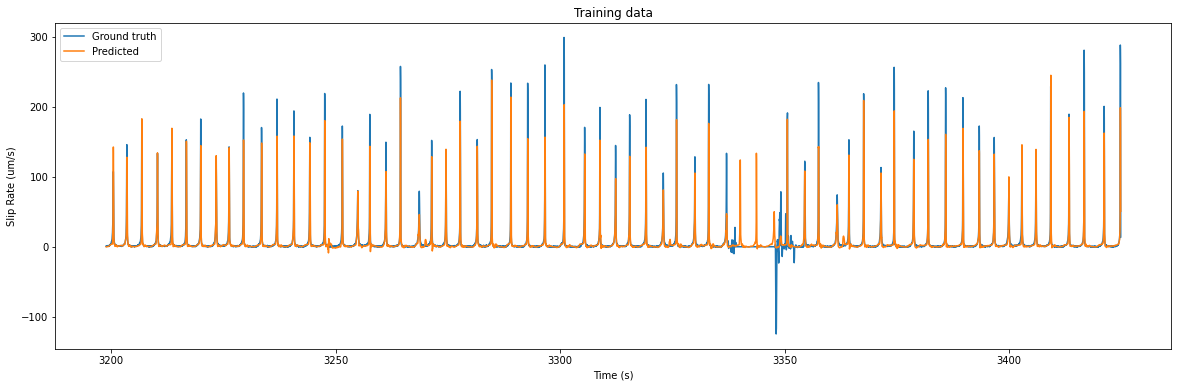

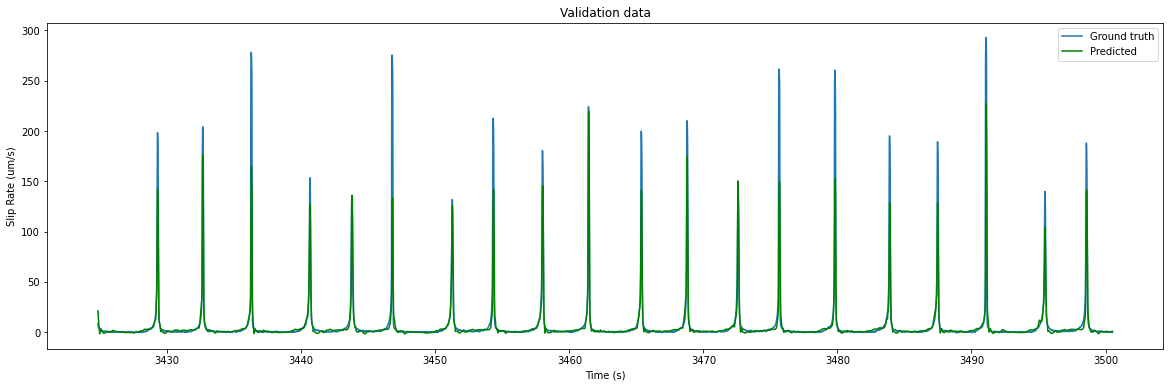

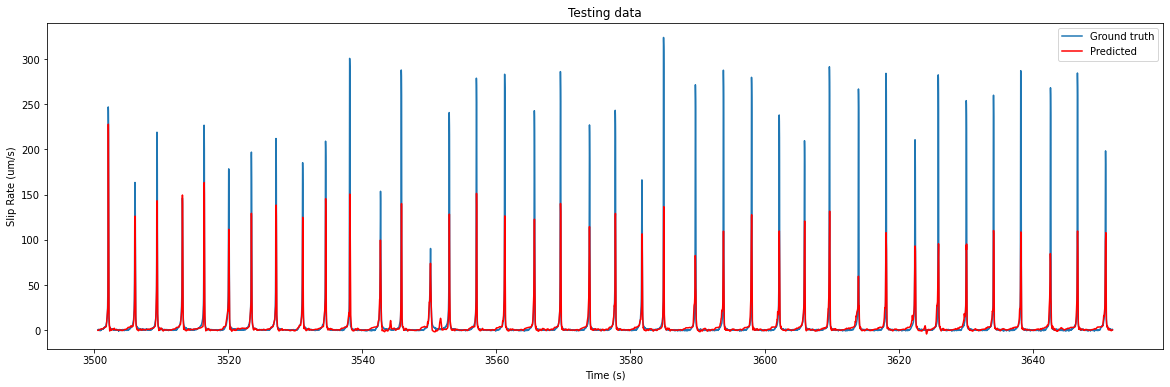

In [17]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')